In [1]:
import torch
import sys
import torch.nn as nn
from metrics import AEBatch, SEBatch
from eval.eval_by_cropping import eval_model
from Datasets.EvalDatasetConstructor import EvalDatasetConstructor
from net.MNet import MNet
%matplotlib inline
# config
config = {
'eval_num':182,
'mode':'crop',
'stage':'numeration',
'gt_map_path_t':"/home/zzn/Documents/Datasets/part_A_final/test_data/gt_map_w_net",
'img_path_t':"/home/zzn/Documents/Datasets/part_A_final/test_data/images",
'gt_path_t':"/home/zzn/Documents/Datasets/part_A_final/test_data/ground_truth"
}

In [2]:
eval_dataset = EvalDatasetConstructor(
    config['img_path_t'],
    config['gt_map_path_t'],
    validate_num=config['eval_num'],
    mode=config['mode'])
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=1)

In [3]:
# obtain the gpu device
assert torch.cuda.is_available()
cuda_device = torch.device("cuda")

# set optimizer and estimator
net = MNet(stage='numeration').cuda()
net.load_state_dict(
    torch.load(
        "/home/zzn/PycharmProjects/MagNet/StateDicts/Hybrid2Loss-7_crop.pkl")
)

ae_batch = AEBatch().cuda()
se_batch = SEBatch().cuda()
criterion = torch.nn.BCELoss(reduction='mean').cuda()
modules = {
    'model': net,
    'shape': None,
    'loss': criterion,
    'ae': ae_batch,
    'se': se_batch
}

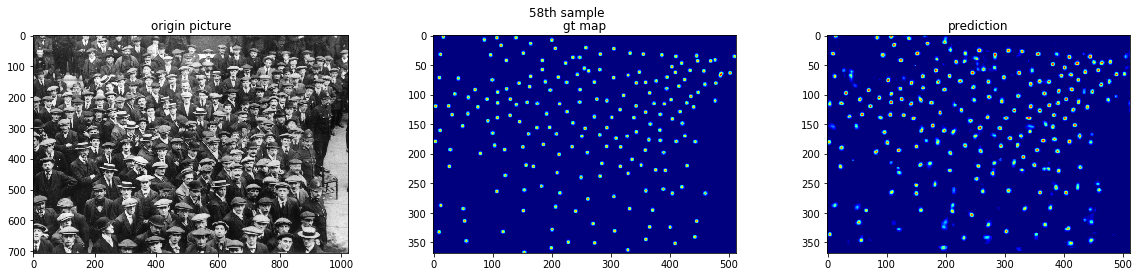

The gt counts of the above sample:198, and the pred counts:197.7342987060547
MAE = 61.21162414550781, MSE = 103.42144775390625, loss = 0.02120250070232202, time cost = 21.198174238204956.


In [4]:
validate_MAE, validate_RMSE, validate_loss, time_cost = eval_model(
    config, eval_loader, modules, True)
sys.stdout.write('MAE = {}, MSE = {}, loss = {}, time cost = {}.\n'.format(
    validate_MAE, validate_RMSE, validate_loss, time_cost))
sys.stdout.flush()

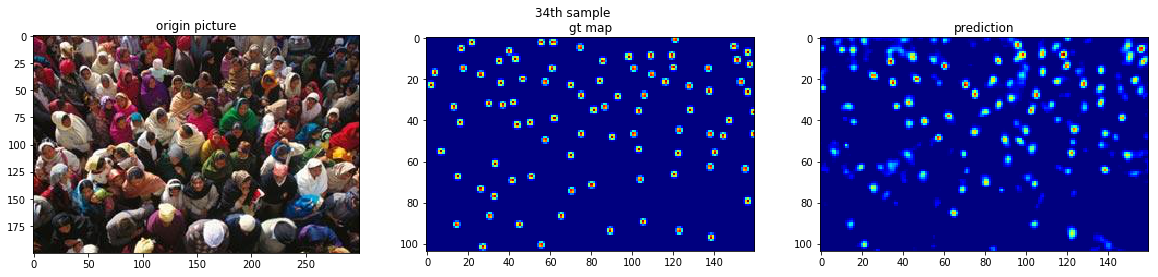

The gt counts of the above sample:89, and the pred counts:75.96141052246094


In [6]:
import random
import time
import math
import numpy as np
import sys
from utils import show
import torch
from PIL import Image
import scipy.io as scio
kernel = torch.ones([1, 1, 2, 2], dtype=torch.float32).cuda()
MAE_ = []
MSE_ = []
loss_ = []
time_cost = 0
rand_number = random.randint(0, config['eval_num'] - 1)
counter = 0
for eval_img_index, eval_img, eval_gt in eval_loader:
    start = time.time()
    eval_patchs = torch.squeeze(eval_img)
    eval_gt_shape = eval_gt.shape
    pad_h = 0 if (eval_gt_shape[2] % 2 == 0) else 1
    pad_w = 0 if (eval_gt_shape[2] % 2 == 0) else 1
    eval_gt = torch.nn.functional.conv2d(
        torch.nn.functional.pad(eval_gt, [pad_w, 0, pad_h, 0]),
        kernel,
        stride=2)

    prediction_map = torch.zeros(eval_gt_shape).cuda()
    with torch.no_grad():
        eval_prediction = net(eval_patchs)
        eval_patchs_shape = eval_prediction.shape
        torch.cuda.empty_cache()
    for i in range(3):
        for j in range(3):
            start_h = math.floor(eval_patchs_shape[2] / 4)
            start_w = math.floor(eval_patchs_shape[3] / 4)
            valid_h = eval_patchs_shape[2] // 2
            valid_w = eval_patchs_shape[3] // 2
            h_pred = math.floor(3 * eval_patchs_shape[2] /
                                4) + (eval_patchs_shape[2] // 2) * (i - 1)
            w_pred = math.floor(3 * eval_patchs_shape[3] /
                                4) + (eval_patchs_shape[3] // 2) * (j - 1)
            if i == 0:
                valid_h = math.floor(3 * eval_patchs_shape[2] / 4)
                start_h = 0
                h_pred = 0
            elif i == 2:
                valid_h = math.ceil(3 * eval_patchs_shape[2] / 4)

            if j == 0:
                valid_w = math.floor(3 * eval_patchs_shape[3] / 4)
                start_w = 0
                w_pred = 0
            elif j == 2:
                valid_w = math.ceil(3 * eval_patchs_shape[3] / 4)
            prediction_map[:, :, h_pred:h_pred + valid_h, w_pred:w_pred +
                           valid_w] += eval_prediction[
                               i * 3 + j:i * 3 + j + 1, :, start_h:start_h +
                               valid_h, start_w:start_w + valid_w]

    torch.cuda.synchronize()
    end = time.time()
    time_cost += (end - start)

    prediction_map = torch.nn.functional.conv2d(
        torch.nn.functional.pad(prediction_map, [pad_w, 0, pad_h, 0]),
        kernel,
        stride=2)

    gt_path = config['gt_path_t'] + "/GT_IMG_" + str(
        eval_img_index.cpu().numpy()[0]) + ".mat"
    loss = criterion(prediction_map, eval_gt)
    loss_.append(loss.data.item())
    gt_counts = len(scio.loadmat(gt_path)['image_info'][0][0][0][0][0])
    batch_ae = ae_batch(prediction_map, gt_counts).data.cpu().numpy()
    batch_se = se_batch(prediction_map, gt_counts).data.cpu().numpy()

    validate_pred_map = np.squeeze(
        prediction_map.permute(0, 2, 3, 1).data.cpu().numpy())
    validate_gt_map = np.squeeze(
        eval_gt.permute(0, 2, 3, 1).data.cpu().numpy())
    pred_counts = np.sum(validate_pred_map)
    # random show 1 sample
    if rand_number == counter and True:
        origin_image = Image.open(config['img_path_t'] + "/IMG_" +
                                  str(eval_img_index.numpy()[0]) + ".jpg")
        show(origin_image, validate_gt_map, validate_pred_map,
             eval_img_index.numpy()[0])
        sys.stdout.write(
            'The gt counts of the above sample:{}, and the pred counts:{}\n'.
            format(gt_counts, pred_counts))

    MAE_.append(batch_ae)
    MSE_.append(batch_se)
    counter += 1

    # calculate the validate loss, validate MAE and validate RMSE
MAE_ = np.reshape(MAE_, [-1])
MSE_ = np.reshape(MSE_, [-1])
loss_ = np.reshape(loss_, [-1])
validate_MAE = np.mean(MAE_)
validate_RMSE = np.sqrt(np.mean(MSE_))
validate_loss = np.mean(loss_)

In [7]:
print(validate_loss, validate_MAE, validate_RMSE)

0.0007601317350006187 61.13582 98.769295
